# Libraries

In [2]:
import pickle
import pandas as pd
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
#from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

# Loading the Files

Download the csv files into the `data/` directory.

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays wit

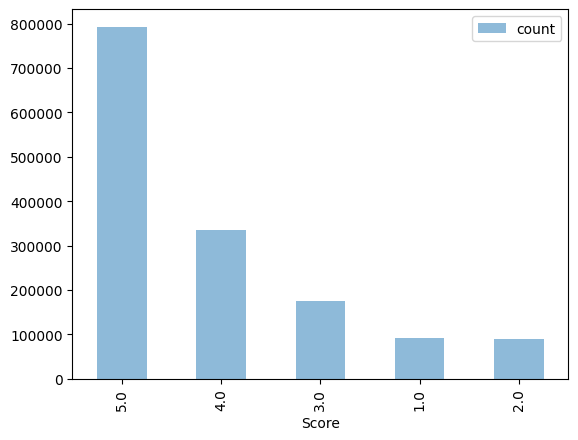


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [3]:
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

# Adding Features

In [4]:
def add_features_to(df):
    # This is where you can do all your feature extraction

    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)

    df['Summary'] = df['Summary'].fillna("").str.len()
    
    df['Text'] = df['Text'].fillna("").str.len()

    return df

# Load the feature extracted files if they've already been generated
if exists('./data/X_train.csv'):
    X_train = pd.read_csv("./data/X_train.csv")
if exists('./data/X_submission.csv'):
    X_submission = pd.read_csv("./data/X_submission.csv")

else:
    # Process the DataFrame
    train = add_features_to(trainingSet)

    # Merge on Id so that the submission set can have feature columns as well
    X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id')
    X_submission = X_submission.drop(columns=['Score_x'])
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})

    # The training set is where the score is not null
    X_train =  train[train['Score'].notnull()]

    X_submission.to_csv("./data/X_submission.csv", index=False)
    X_train.to_csv("./data/X_train.csv", index=False)

# Sample + Split into training and testing set

In [5]:
# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train.drop(columns=['Score']),
    X_train['Score'],
    test_size=1/4.0,
    random_state=0
)

# Feature Selection

In [6]:
features = ['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Helpfulness', 'SummaryLength', 'TextLength'] #'Time', 

# X_train_select = X_train[features]
# X_test_select = X_test[features]
# X_submission_select = X_submission[features]
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[features])
X_test_scaled = scaler.transform(X_test[features])
X_submission_scaled = scaler.transform(X_submission[features])

# Model Creation

In [7]:
# Learn the model
#model = KNeighborsClassifier(n_neighbors=9).fit(X_train_select, Y_train)
# model = RandomForestClassifier().fit(X_train_select, Y_train)

# Predict the score using the model
# Y_test_predictions = model.predict(X_test_select)
# param_grid = {
#     'n_estimators': [100, 200],
#     'max_depth': [10, 20, None],
#     'max_features': ['auto', 'sqrt']
# }
grid_search = RandomForestClassifier(random_state=0,max_depth= 10, m0ax_features='sqrt', n_estimators=200)
grid_search.fit(X_train_scaled, Y_train)
model = grid_search.best_estimator_

# Predict on the test set
Y_test_predictions = model.predict(X_test_scaled)

# Evaluate model
print("Best parameters found: ", grid_search.best_params_)
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))
print("Classification report:\n", classification_report(Y_test, Y_test_predictions))

C:\Users\etanm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
18 fits failed out of a total of 36.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
18 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\etanm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\etanm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-pack

Best parameters found:  {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
Accuracy on testing set =  0.5523407372298942
Classification report:
               precision    recall  f1-score   support

         1.0       0.46      0.39      0.43     22906
         2.0       0.29      0.03      0.05     22406
         3.0       0.28      0.04      0.07     44171
         4.0       0.32      0.01      0.02     83810
         5.0       0.57      0.98      0.72    198043

    accuracy                           0.55    371336
   macro avg       0.39      0.29      0.25    371336
weighted avg       0.45      0.55      0.42    371336



# Model Evaluation

Accuracy on testing set =  0.5523407372298942


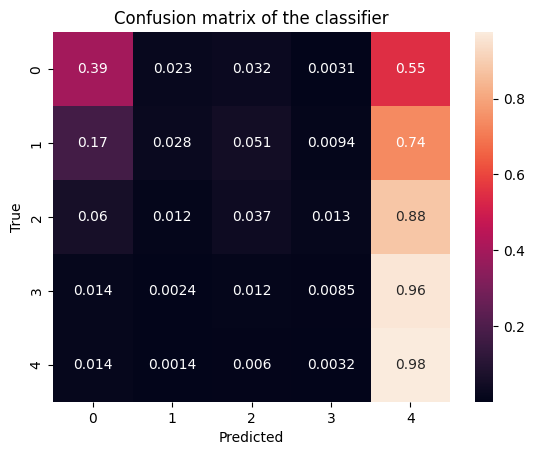

In [8]:
# Evaluate your model on the testing set
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Create submission file

In [9]:
# Create the submission file
X_submission['Score'] = model.predict(X_submission_scaled)
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)

NameError: name 'X_submission_select' is not defined